In [14]:
from scipy import stats
import math

class City:
    def __init__(self, name, population,mean_leave):
        self.name = name
        self.population = population
        self.mean_leave = mean_leave

    def onramp(self, time):
        st_dev = 33
        commuters_percentage = 0.01
        #Calculate the z-score for the normal dist. at the current time and the last time
        z_now = (time-self.mean_leave) / st_dev
        z_last = ((time-1)-self.mean_leave) / st_dev
        #Calculate the probability of a car entering the highway in the last minute
        cdf_now = stats.norm.cdf(z_now)
        cdf_last = stats.norm.cdf(z_last)
        probability = cdf_now - cdf_last
        #Calculate the expected number of cars entering in the last minute
        cars_coming_on = math.floor(probability*commuters_percentage*self.population)
        return cars_coming_on
    
class Road:
    global free_flow_speed, jam_density
    free_flow_speed = 110/60 #110 is the free flow speed in km/h, so 110/60 is km/min
    jam_density = 135
    def __init__(self, length, lanes, onramp_city):
        self.length = length
        self.lanes= lanes
        self.city = onramp_city
        self.vehicle_count = 0
        self.density = 0
        self.speed = free_flow_speed*(1 - (self.density/jam_density))
        #Assumption: The highway never gets fully jammed, so outflow never fully stops
        self.max_vehicles = jam_density*self.lanes*self.length*0.8
        
    def outflow(self):
        self.speed = free_flow_speed*(1 - (self.density/jam_density))
        outflow = self.density*self.speed
        return outflow
    
    def update(self,time,road_inflow):
        onramp_inflow = self.city.onramp(time)
        outflow = self.outflow()
        #Assumption: Once the highway is jammed, all cars that would come on exit the highway
        self.vehicle_count = min(math.floor(self.vehicle_count + onramp_inflow + road_inflow - outflow),self.max_vehicles)
        self.density = self.vehicle_count / (self.lanes * self.length)
        return {'Count':self.vehicle_count,'Onramp':onramp_inflow,'Road Inflow':road_inflow,'Outflow':outflow}

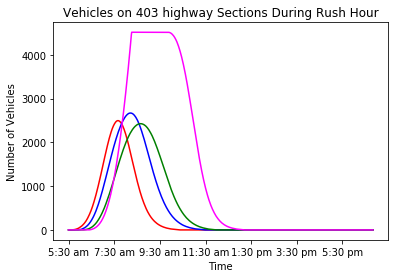

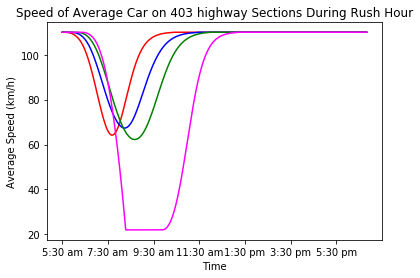

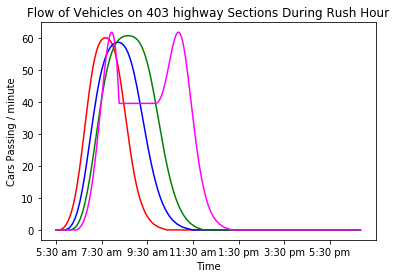

In [16]:
# odeint performed on SIR model
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt
from pylab import * 

#Note: t = 0 is 5:30 am

#Setup Our 4 cities
cities = [
    City(name="Hamilton",population=747545,mean_leave=100),
    City(name="Burlington",population=183314,mean_leave=115),
    City(name="Oakville",population=193832,mean_leave=135),
    City(name="Mississauga",population=721599,mean_leave=155)
]
#Setup Our 4 road segments
roads = [
    Road(length=11.1, lanes=4, onramp_city=cities[0]),
    Road(length=17.0, lanes=3, onramp_city=cities[1]),
    Road(length=13.8, lanes=3, onramp_city=cities[2]),
    Road(length=20.9, lanes=2, onramp_city=cities[3])
]

run_time=800  # run_time*time_step must equal 600, which will go through one rush hour
             # (std dev 33 with peak time for Hamilton route at 100, so 99% of the population will 
             # leave between 5:30 and  )


def initialize():
    global time, speeds_record, vehicles_record, outflow_record
    time = 0
    # list of the initial car populations
    speeds_record = [[road.speed*60] for road in roads]
    vehicles_record = [[road.vehicle_count] for road in roads]
    outflow_record = [[road.outflow()] for road in roads]
    
def observe():
    global time, speeds_record, vehicles_record, outflow_record
    
    #using the road objects vehicle_count to record itself
    for ind in range(len(vehicles_record)):
        speeds_record[ind].append(roads[ind].speed*60)
        vehicles_record[ind].append(roads[ind].vehicle_count)
        outflow_record[ind].append(roads[ind].outflow())
    
def updateall():
    global time
    outflows = [road.outflow() for road in roads]
    roads[0].update(time, 0)
    roads[1].update(time,outflows[0])
    roads[2].update(time,outflows[1])
    roads[3].update(time,outflows[2])
    
    time = time + 1

initialize()

for t in range(run_time):
    updateall()
    observe() 

plt.title("Vehicles on 403 highway Sections During Rush Hour")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(vehicles_record[0], color='red') 
plot(vehicles_record[1], color='blue') 
plot(vehicles_record[2], color='green')
plot(vehicles_record[3], color='magenta')

show()

plt.title("Speed of Average Car on 403 highway Sections During Rush Hour")
plt.xlabel("Time")
plt.ylabel("Average Speed (km/h)")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(speeds_record[0], color='red') 
plot(speeds_record[1], color='blue') 
plot(speeds_record[2], color='green')
plot(speeds_record[3], color='magenta')

show()

plt.title("Flow of Vehicles on 403 highway Sections During Rush Hour")
plt.xlabel("Time")
plt.ylabel("Cars Passing / minute")
plt.xticks((np.arange(0,800,120)),('5:30 am','7:30 am','9:30 am','11:30 am','1:30 pm','3:30 pm','5:30 pm'))

plot(outflow_record[0], color='red') 
plot(outflow_record[1], color='blue') 
plot(outflow_record[2], color='green')
plot(outflow_record[3], color='magenta')

show()

In [19]:
import datetime     
def get_travel_time(start_city_index, start_time):
    time_travelled = 0
    
    #Get the distances at which you cross between roads
    markers = [0]
    distance = 0
    road_ind = 0
    while (road_ind < 4):
        distance += roads[road_ind].length
        markers.append(distance)
        road_ind += 1
    
    dist_travelled = markers[start_city_index]
    
    ind = start_city_index
    
    while (ind<5):
        if (dist_travelled < markers[ind]):
            dist_travelled = dist_travelled + speeds_record[ind-1][start_time + time_travelled]/60
            time_travelled = time_travelled + 1
        else: # Commuter moved to the new section
            ind = ind + 1
    return time_travelled

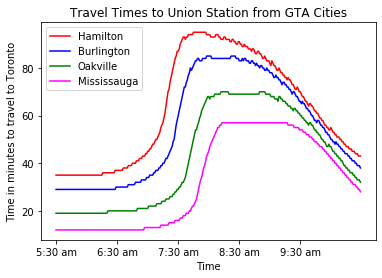

In [24]:
travel_times = [[get_travel_time(ind,start_time) for start_time in range(0,300)] for ind in range(len(roads))]

plt.title('Travel Times')

plt.title("Travel Times to Union Station from GTA Cities")
plt.xlabel("Time")
plt.ylabel("Time in minutes to travel to Toronto")
plt.xticks((np.arange(0,300,60)),('5:30 am','6:30 am','7:30 am','8:30 am','9:30 am','10:30 am'))

plot(travel_times[0], color='red') 
plot(travel_times[1], color='blue') 
plot(travel_times[2], color='green')
plot(travel_times[3], color='magenta')

plt.legend(('Hamilton','Burlington','Oakville','Mississauga'))

show()